In [1]:
import d2l 
from mxnet import *
from mxnet.gluon import nn
npx.set_np()

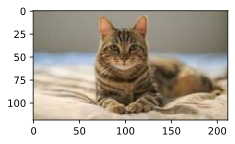

In [3]:
d2l.set_figsize((3.5, 2.5))
img = image.imread('cat.jpg')
d2l.plt.imshow(img.asnumpy())

In [8]:
def apply(img, aug, num_rows= 2, num_cols= 4, scale= 1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

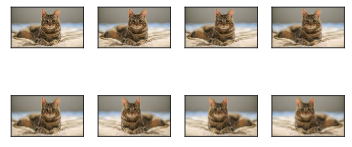

In [9]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

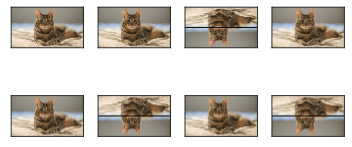

In [10]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

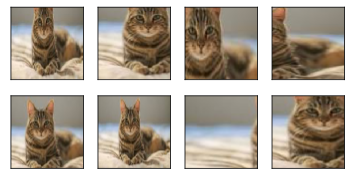

In [11]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop((200, 200), 
                                                          scale= (0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

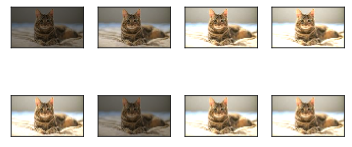

In [12]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

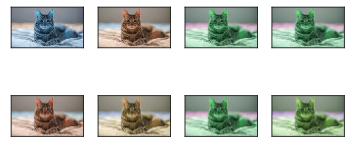

In [13]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

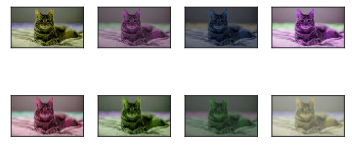

In [14]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(brightness=0.5,
                                                          contrast=0.5,
                                                          saturation=0.5,
                                                          hue=0.5)
apply(img, color_aug)

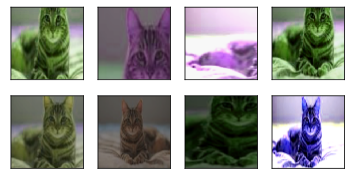

In [15]:
augs = gluon.data.vision.transforms.Compose([
gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])

apply(img, augs)

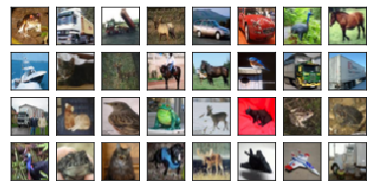

In [16]:
d2l.show_images(gluon.data.vision.CIFAR10(train= True)[0:32][0], 4, 8, scale= 0.8);

In [17]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()
])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()
])

In [18]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train= is_train).transform_first(augs),
    batch_size=batch_size, shuffle=is_train,
    num_workers= d2l.get_dataloader_workers())

In [19]:
def train_batch_ch13(net, features, labels, loss, trainer, 
                    ctx_list, split_f= d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
        pred_shards = [net(X_shards) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard 
             in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    
    trainer.step(labels.shape[0], ignore_stale_grad= True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard)
                       for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum


In [23]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
              ctx_list= d2l.try_all_gpus(), split_f= d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel= 'epoch', xlim= [0, num_epochs], ylim=[0,1],
                           legend= ['train_loss', 'train_acc', 'test_acc'])
    
    for epoch in range(num_epochs):
        metric= d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            
            if (i+1) % (num_batches // 5) == 0:
                animator.add(epoch+1 / num_batches,
                            (metric[0] / metric[2], metric[1] / metric[3],
                            None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch+1, (None, None, test_acc))

In [24]:
batch_size, ctx, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init= init.Xavier(), ctx= ctx)

def train_with_data_aug(train_augs, test_augs, net, lr= 0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                           {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, ctx)

ValueError: Deferred initialization failed because shape cannot be inferred. Argument data must be Symbol instances, but got [<_Symbol data>]

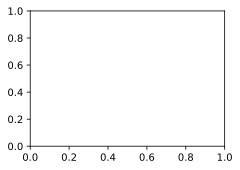

In [25]:
train_with_data_aug(train_augs, test_augs, net)